In [71]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline
pd.set_option('max_columns', None)

In [72]:
df = pd.read_csv('./data/diabetic_data.csv', na_values='?')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Missing Values

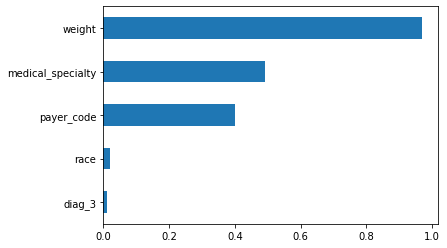

In [73]:
missing = round((df.isna().sum()/len(df)),2).sort_values(ascending = True)
missing = missing[missing > 0]
missing.plot(kind='barh')

In [74]:
# drop weight
drop_cols = ['encounter_id', 'weight','admission_type_id',
 'discharge_disposition_id',
 'admission_source_id', 'diag_1','diag_2','diag_3']
df.drop(drop_cols, axis=1, inplace = True)

df.drop_duplicates('patient_nbr', keep = 'first')
df.drop('patient_nbr', axis = 1, inplace = True)

In [75]:
# payer code - mode
df.loc[df['payer_code'].isnull(), 'payer_code'] = df['payer_code'].value_counts().index[0]

In [76]:
# drop medical specialty column
print('Number of unique medical specialty',str(len(df['medical_specialty'].unique())))
df.drop('medical_specialty', axis=1, inplace=True)

Number of unique medical specialty 73


In [77]:
# remaining missing values
df.dropna(axis=0, inplace=True)
print('Number of missing values: ',str((df.isna().sum() > 0).sum()))

Number of missing values:  0


In [78]:
## gender
df = df[df['gender']!='Unknown/Invalid']

# Feature Engineering

In [79]:
df['age'] = df['age'].map({'[10-20)':1, '[20-30)':2, '[30-40)':3, '[40-50)':4, '[50-60)':5, '[60-70)':6,
                           '[70-80)':7, '[80-90)':8, '[90-100)':9, '[0-10)':0})

In [80]:
df['max_glu_serum'] = df['max_glu_serum'].map({'None':0, 'Norm':100, '>200':200, '>300':300})

In [81]:
df['A1Cresult']= df.A1Cresult.map({'None':0,'Norm':3,'>7':7,'>8':8})

In [82]:
medication = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

for med in medication:
    df[med] = df[med].map({'Up':1, 'Down':1, 'Steady':1, 'No':0})

In [83]:
df['change'] = df['change'].map({'Ch':1,'No':0})

In [84]:
df['diabetesMed'] = df.diabetesMed.map({'Yes':1, 'No':0})

In [85]:
df['readmitted'] = df.readmitted.map({'NO':0, '>30':0, '<30':1})

# Preprocessing Numeric and Categorical Features

## Numeric Features

In [86]:
categorical = []
continuous = []

for col in df.columns:
    if df[col].dtype == 'O':
        categorical.append(col)
    elif col != 'readmitted':
        continuous.append(col)
        



In [87]:
print(categorical, end = '\n')
print(continuous)

['race', 'gender', 'payer_code']
['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


## Encoding / Scaling

In [88]:
X = df.drop('readmitted', axis = 1)
y = df['readmitted']

In [89]:
X = pd.get_dummies(X, columns = categorical)

In [90]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

## Train Test Split / SMOTE

In [91]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, stratify = y, random_state = 42)

In [92]:
X_train

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,payer_code_BC,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC
94614,-0.059914,0.201391,1.011756,-0.786851,0.119887,-0.292416,-0.214200,0.280717,0.810344,-0.213874,-0.418572,2.024022,-0.124932,-0.083933,-0.029242,4.331744,-0.00317,-0.377313,-0.341277,-0.014872,-0.278806,-0.258393,-0.055178,-0.019547,-0.005491,-0.019803,0.0,0.0,0.936650,-0.082956,-0.011432,-0.00317,0.0,-0.00317,1.080328,0.548363,-0.489164,-0.080526,0.554439,-0.144575,-0.123932,0.925775,-0.925775,-0.218689,-0.038072,-0.140240,-0.159324,-0.073459,-0.256194,-1.590940,-0.189075,-0.02783,9.801294,-0.030915,-0.077171,-0.023518,-0.224233,-0.153284,-0.035468
51782,1.194505,0.536180,0.910210,0.974046,0.366200,1.274002,-0.214200,-0.505840,0.810344,-0.213874,-0.418572,-0.494066,-0.124932,-0.083933,-0.029242,-0.230854,-0.00317,-0.377313,2.930170,-0.014872,-0.278806,-0.258393,-0.055178,-0.019547,-0.005491,-0.019803,0.0,0.0,-1.067634,-0.082956,-0.011432,-0.00317,0.0,-0.00317,-0.925644,0.548363,-0.489164,-0.080526,0.554439,-0.144575,-0.123932,-1.080176,1.080176,-0.218689,-0.038072,-0.140240,-0.159324,-0.073459,-0.256194,0.628559,-0.189075,-0.02783,-0.102027,-0.030915,-0.077171,-0.023518,-0.224233,-0.153284,-0.035468
55080,-0.687124,-0.468187,0.097841,1.561012,0.735668,-0.292416,-0.214200,-0.505840,-0.747262,-0.213874,-0.418572,-0.494066,-0.124932,-0.083933,-0.029242,-0.230854,-0.00317,-0.377313,-0.341277,-0.014872,-0.278806,-0.258393,-0.055178,-0.019547,-0.005491,-0.019803,0.0,0.0,0.936650,-0.082956,-0.011432,-0.00317,0.0,-0.00317,-0.925644,0.548363,-0.489164,-0.080526,0.554439,-0.144575,-0.123932,0.925775,-0.925775,-0.218689,-0.038072,-0.140240,-0.159324,-0.073459,-0.256194,-1.590940,5.288915,-0.02783,-0.102027,-0.030915,-0.077171,-0.023518,-0.224233,-0.153284,-0.035468
80378,0.567295,-1.137765,-0.359116,-0.786851,-0.742207,-0.292416,0.849657,0.280717,-0.747262,-0.213874,-0.418572,-0.494066,-0.124932,-0.083933,-0.029242,-0.230854,-0.00317,-0.377313,-0.341277,-0.014872,-0.278806,-0.258393,-0.055178,-0.019547,-0.005491,-0.019803,0.0,0.0,-1.067634,-0.082956,-0.011432,-0.00317,0.0,-0.00317,-0.925644,-1.823609,2.044304,-0.080526,-1.803626,-0.144575,-0.123932,0.925775,-0.925775,-0.218689,-0.038072,-0.140240,-0.159324,-0.073459,-0.256194,0.628559,-0.189075,-0.02783,-0.102027,-0.030915,-0.077171,-0.023518,-0.224233,-0.153284,-0.035468
71486,-0.059914,0.201391,1.417940,-0.199885,0.858824,2.840419,1.913513,-0.505840,0.810344,-0.213874,-0.418572,2.024022,-0.124932,-0.083933,-0.029242,-0.230854,-0.00317,-0.377313,-0.341277,-0.014872,-0.278806,-0.258393,18.123016,-0.019547,-0.005491,-0.019803,0.0,0.0,0.936650,-0.082956,-0.011432,-0.00317,0.0,-0.00317,1.080328,0.548363,-0.489164,-0.080526,0.554439,-0.144575,-0.123932,-1.080176,1.080176,-0.218689,-0.038072,7.130621,-0.159324,-0.073459,-0.256194,-1.590940,-0.189075,-0.02783,-0.102027,-0.030915,-0.077171,-0.023518,-0.224233,-0.153284,-0.035468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54780,1.194505,1.540546,1.468714,-0.786851,-0.495894,-0.292416,-0.214200,0.280717,0.810344,-0.213874,-0.418572,-0.494066

Text(0.5, 1.0, 'Imbalanced Dataset')

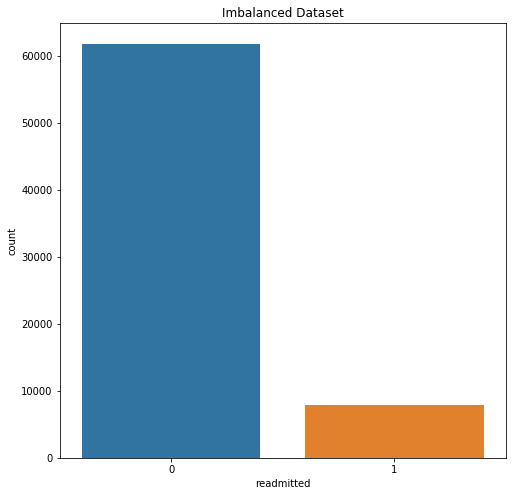

In [93]:
plt.figure(figsize=(8,8))
sns.countplot(y_train)
plt.title('Imbalanced Dataset')

In [95]:
# SMOTE 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# Helper Functions

In [96]:
# Plot ROC Curve
def plot_roc_curve(model, title = "ROC Curve", X_test = X_test, y_test = y_test):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (10,8))
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = "AUC = %0.2f"%roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1],[0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.show()
    
# Print Confusion Matrix / Classification Report
def show_metrics(model, X_test = X_test, y_test = y_test):
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))
    print('-'*40)
    print(confusion_matrix(y_test, preds))

In [103]:
# Plotting Feature Importance
def plot_feature_importance(values, names, model_name, n_features=10):
    '''Plots feature importances 
    
    Plots top important features for a given model
    
    Args:
        values: 
            Feature importance values for a given model
        names: 
            Feature names from training data set
        n_features: 
            Number of features to show - default is 10
            
    Returns: 
        A bar plot showing the top n_features. 
        
    '''
    # make arrays for feature importance values and names 
    feature_importance = np.array(values)
    feature_names = np.array(names)
    
    # create DataFrame and sort by feature importance
    data = {'Feature':feature_names, 'Feature Importance':feature_importance}
    fidf = pd.DataFrame(data)
    fidf = fidf.sort_values('Feature Importance', ascending=False).head(n_features)
    
    # plot figure
    plt.figure(figsize = (10,8))
    sns.barplot(x=fidf['Feature Importance'], y=fidf['Feature'])
    plt.title(model_name + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    
    
    
    

# Training Machine Learning Models

In [104]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score


## Random Forest Classifier

In [105]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs = -1)

rf_clf.fit(X_train_res, y_train_res)
rf_preds = rf_clf.predict(X_test)

In [106]:
show_metrics(rf_clf)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     26497
           1       0.32      0.03      0.06      3351

    accuracy                           0.88     29848
   macro avg       0.61      0.51      0.50     29848
weighted avg       0.83      0.88      0.84     29848

----------------------------------------
[[26260   237]
 [ 3239   112]]


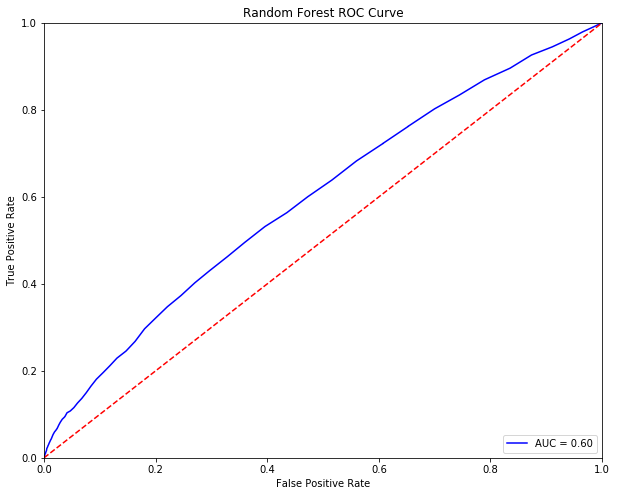

In [107]:
plot_roc_curve(rf_clf, title = "Random Forest ROC Curve")

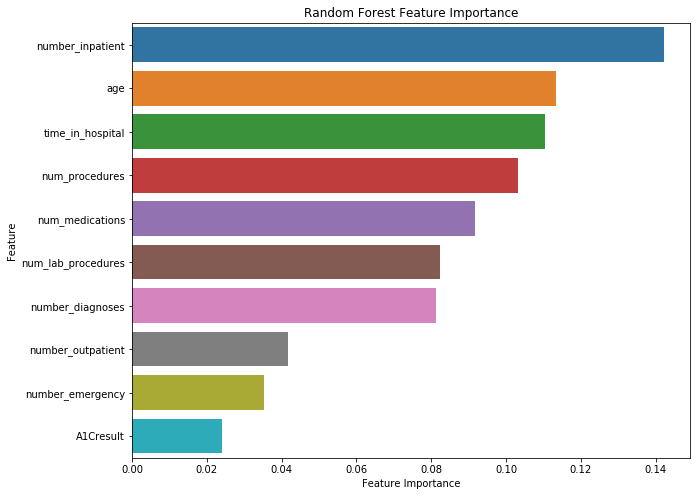

In [108]:
plot_feature_importance(rf_clf.feature_importances_, X_train_res.columns, 'Random Forest')

## Logistic Regression

In [109]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train_res, y_train_res)
preds = logmodel.predict(X_test)

In [110]:
show_metrics(logmodel)

              precision    recall  f1-score   support

           0       0.92      0.65      0.76     26497
           1       0.16      0.53      0.25      3351

    accuracy                           0.63     29848
   macro avg       0.54      0.59      0.50     29848
weighted avg       0.83      0.63      0.70     29848

----------------------------------------
[[17130  9367]
 [ 1562  1789]]


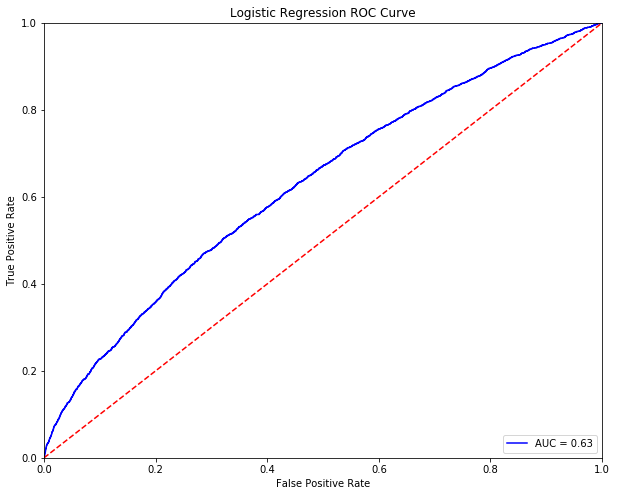

In [111]:
plot_roc_curve(logmodel, 'Logistic Regression ROC Curve')

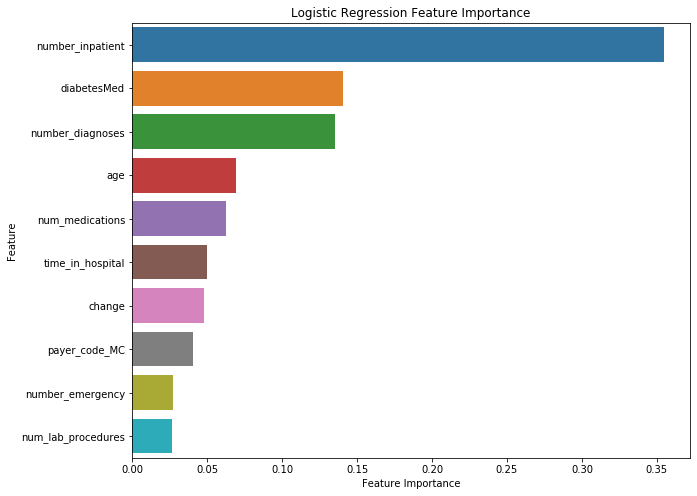

In [131]:
plot_feature_importance(logmodel.coef_.reshape(59,), X_train_res.columns, 'Logistic Regression')

## Logistic Regression + Bootstrap Aggregation

In [152]:
from sklearn.ensemble import BaggingClassifier

lr_bagger = BaggingClassifier(logmodel, n_jobs = -1, random_state = 42)
lr_bagger.fit(X_train_res, y_train_res)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=False,
                  random_state=42, ver

In [150]:
show_metrics(lr_bagger)

              precision    recall  f1-score   support

           0       0.92      0.63      0.74     26497
           1       0.16      0.56      0.25      3351

    accuracy                           0.62     29848
   macro avg       0.54      0.59      0.50     29848
weighted avg       0.83      0.62      0.69     29848

----------------------------------------
[[16565  9932]
 [ 1472  1879]]


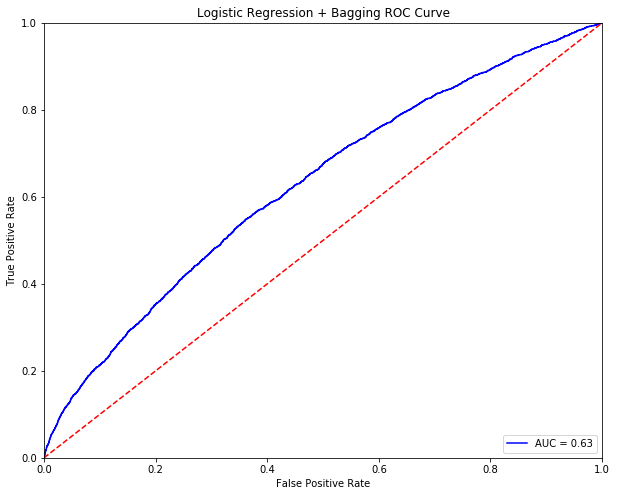

In [151]:
plot_roc_curve(lr_bagger, "Logistic Regression + Bagging ROC Curve")

In [161]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':list(range(10,50,5)),
               'max_features':[0.4,0.5,0.6,0.7,0.8]}

lr_bagger_grid = GridSearchCV(lr_bagger, param_grid=param_grid, n_jobs=-1, 
                              scoring='roc_auc', verbose=1)

lr_bagger_grid.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 14.5min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=BaggingClassifier(base_estimator=LogisticRegression(C=1.0,
                                                                           class_weight=None,
                                                                           dual=False,
                                                                           fit_intercept=True,
                                                                           intercept_scaling=1,
                                                                           l1_ratio=None,
                                                                           max_iter=100,
                                                                           multi_class='auto',
                                                                           n_jobs=None,
                                                                           penalty='l2',
                                                        

In [163]:
lr_bagger_grid.best_params_

grid_lr_bagger = lr_bagger_grid.best_estimator_

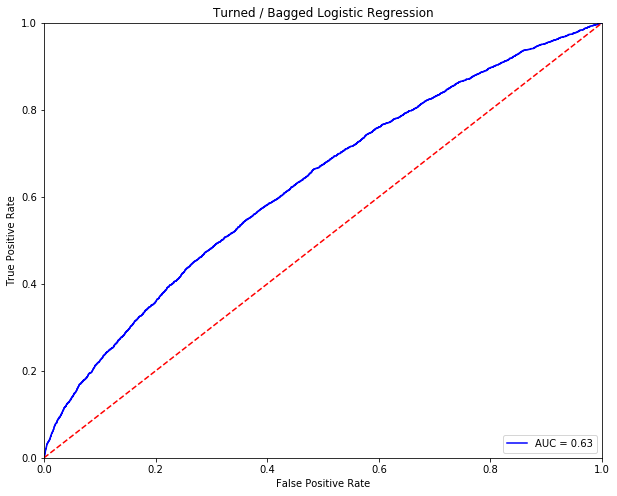

In [164]:
plot_roc_curve(grid_lr_bagger,'Turned / Bagged Logistic Regression')

## XGBoost Classifier

In [39]:
import xgboost as xgb 

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed = 42)
xgb_clf.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [40]:
show_metrics(xgb_clf)

              precision    recall  f1-score   support

           0       0.90      0.87      0.89     26497
           1       0.21      0.28      0.24      3351

    accuracy                           0.80     29848
   macro avg       0.56      0.57      0.56     29848
weighted avg       0.83      0.80      0.81     29848

----------------------------------------
[[23051  3446]
 [ 2424   927]]


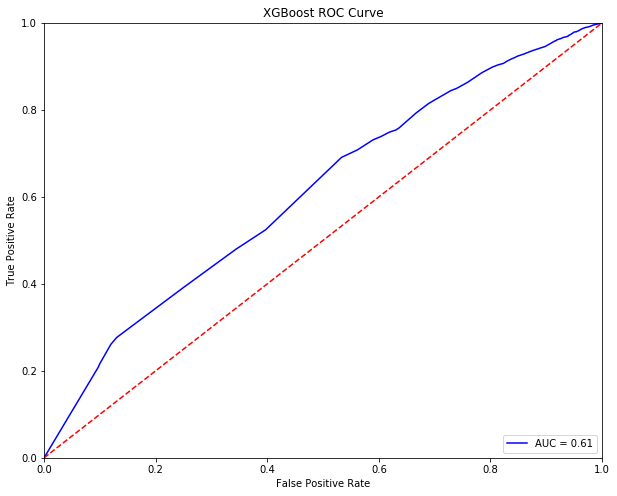

In [41]:
plot_roc_curve(xgb_clf, title="XGBoost ROC Curve")

# Ensembling

In [42]:
from sklearn.ensemble import VotingClassifier

voter = VotingClassifier(estimators = [('Random Forest',rf_clf),('Bagged Logistic Regression',lr_bagger),
                                       ('XGBoost',xgb_clf)], voting='soft')

voter.fit(X_train_res, y_train_res)


VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.

In [43]:
show_metrics(voter)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     26497
           1       0.24      0.20      0.22      3351

    accuracy                           0.84     29848
   macro avg       0.57      0.56      0.56     29848
weighted avg       0.83      0.84      0.83     29848

----------------------------------------
[[24355  2142]
 [ 2681   670]]


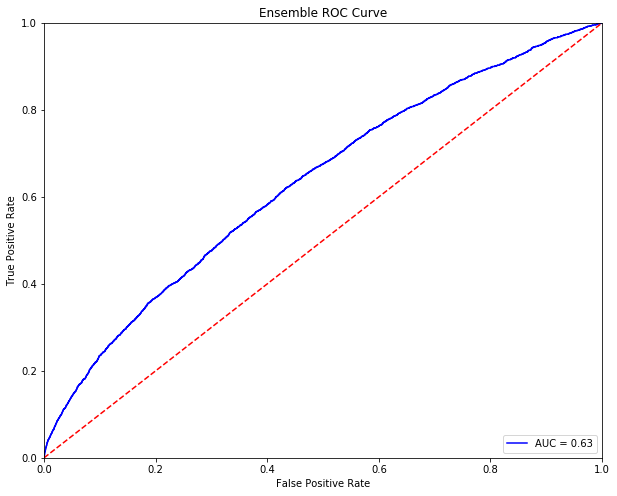

In [44]:
plot_roc_curve(voter, title="Ensemble ROC Curve")

In [ ]:
# To Do 

# DecisionTreeClassifier

## Further Work ## 
# pipeline


## Tuning Random Forest Hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

n_estimators = list(np.arange(200, 1000, 100))
max_depth = [2,3,4]
max_features = ['log2','auto','sqrt']

rf_params = {'n_estimators':n_estimators, 
             'max_depth':max_depth,
             'max_features':max_features}

grid_rf = GridSearchCV(estimator=rf_clf, 
                       param_grid=rf_params, 
                       scoring='roc_auc',
                       cv=3, 
                       verbose=1, 
                       n_jobs=-1)

grid_rf.fit(X_train_res, y_train_res)

show_metrics(grid_rf)

plot_roc_curve(best_rf, title = "Grid Search Random Forest ROC Curve")

## Grid Search With XGB

In [ ]:
param_grid = {'n_estimators':np.arange(5,100,5),
              'max_depth':[2,4,6,8]}


grid_xgb = GridSearchCV(xgb_clf, param_grid=param_grid, scoring='roc_auc', 
                        cv=4, verbose=1, n_jobs=-1)

grid_xgb.fit(X_train_res, y_train_res)

best_xgb = grid_xgb.best_estimator_
show_metrics(best_xgb)

plot_roc_curve(best_xgb, "Grid Search XGB Boost ROC Curve")